# **Prediction of a Stocks Portfolio Return using Recurrent Neural Networks**
_____

Author: **Daniel Eduardo López**

#####<a href="https://www.linkedin.com/in/daniel-eduardo-lopez"> LinkedIn </a> 

#####<a href="https://github.com/DanielEduardoLopez"> GitHub </a>

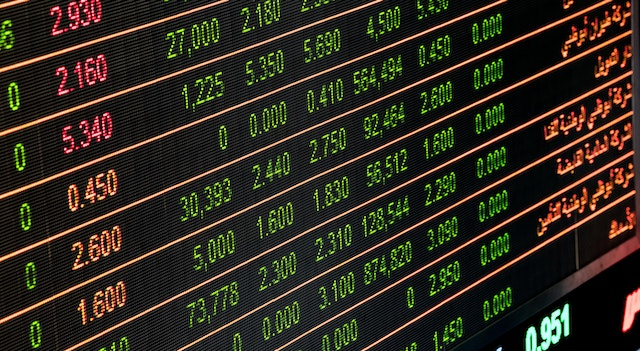

##### Image Credit: <a href="https://www.pexels.com/es-es/foto/numeros-en-el-monitor-534216/"> Pixabay </a>


___
## **1. Goal**
___

The purpose of the present notebook is to define the components of the stock portofolio, retrieve the stocks value data by using the Yahoo Finance API, calculate the correspondent returns and optimize the portfolio composition to maximize the return.


___
## **2. Data Collection**
___

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install yfinance # Python API for retrieving stock data from Yahoo Finance
import yfinance as yf
!pip install cvxopt # Convex Solver for portfolio optimization
import cvxopt as opt
from cvxopt import blas, solvers
from IPython.display import set_matplotlib_formats
from matplotlib.ticker import PercentFormatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
# Setting theme and Plot resolution
sns.set_theme(context = 'notebook', style = 'darkgrid')
mpl.rcParams["figure.dpi"] = 100
set_matplotlib_formats('svg')

For simplicity, in the present project, only 10 stocks selected from the biggest companies in the world by market capitalization <a href="https://www.investopedia.com/biggest-companies-in-the-world-by-market-cap-5212784">(Johnston, 2022)</a> were used to build the portfolio:
1. Apple Inc. (**AAPL**)
2. Saudi Aramco (**2222.SR**) 
3. Microsoft Corp. (**MSFT**)
4. Alphabet Inc. (**GOOGL**)
5. Amazon.com Inc. (**AMZN**)
6. Tesla Inc. (**TSLA**)
7. Berkshire Hathaway Inc. (**BRK-B**)
8. NVIDIA Corp. (**NVDA**)
9. Taiwan Semiconductor Manufacturing Co. Ltd. (**TSM**)
10. Meta Platforms Inc. (**META**)

On the other hand, stock value data was retrieved from the previous three years, i.e., **from 2020-01-01 to 2023-01-09**.

In [3]:
# List of companies whose stock data will be retrieved
stocks = ["AAPL", "2222.SR", "MSFT", "GOOGL", "AMZN", "TSLA", "BRK-B", "NVDA", "TSM", "META"]

# Retrieval of the Stock Data
df = yf.download(stocks, start="2020-01-01", end="2023-01-09")
df

[*********************100%***********************]  10 of 10 completed


Adj Close                                                \
              2222.SR        AAPL       AMZN       BRK-B      GOOGL   
Date                                                                  
2020-01-01  25.947227         NaN        NaN         NaN        NaN   
2020-01-02  25.984190   73.561554  94.900497  228.389999  68.433998   
2020-01-03        NaN   72.846375  93.748497  226.179993  68.075996   
2020-01-05  25.540649         NaN        NaN         NaN        NaN   
2020-01-06  25.503687   73.426826  95.143997  226.990005  69.890503   
...               ...         ...        ...         ...        ...   
2023-01-03  32.150002  125.070000  85.820000  309.910004  89.120003   
2023-01-04  31.700001  126.360001  85.139999  314.549988  88.080002   
2023-01-05  31.549999  125.019997  83.120003  312.899994  86.199997   
2023-01-06        NaN  129.619995  86.080002  318.690002  87.339996   
2023-01-08  31.500000         NaN        NaN         NaN        NaN   

                                                                       ...  \
                  META        MSFT        NVDA        TSLA        TSM  ...   
Date                                                                   ...   
2020-01-01         NaN         NaN         NaN         NaN        NaN  ...   
2020-01-02  209.779999  156.151932   59.770554   28.684000  56.350277  ...   
2020-01-03  208.669998  154.207565   58.813866   29.534000  54.491966  ...   
2020-01-05         NaN         NaN         NaN         NaN        NaN  ...   
2020-01-06  212.600006  154.606201   59.060505   30.102667  53.863136  ...   
...                ...         ...         ...         ...        ...  ...   
2023-01-03  124.739998  239.580002  143.149994  108.099998  74.029999  ...   
2023-01-04  127.370003  229.100006  147.490005  113.639999  76.320000  ...   
2023-01-05  126.940002  222.309998  142.649994  110.339996  75.730003  ...   
2023-01-06  130.020004  224.929993  148.589996  113.059998  78.070000  ...   
2023-01-08         NaN         NaN         NaN         NaN        NaN  ...   

                Volume                                                  \
               2222.SR         AAPL        AMZN      BRK-B       GOOGL   
Date                                                                     
2020-01-01   8517342.0          NaN         NaN        NaN         NaN   
2020-01-02  11430744.0  135480400.0  80580000.0  3764000.0  27278000.0   
2020-01-03         NaN  146322800.0  75288000.0  3023900.0  23408000.0   
2020-01-05  25239125.0          NaN         NaN        NaN         NaN   
2020-01-06  23401835.0  118387200.0  81236000.0  4263000.0  46768000.0   
...                ...          ...         ...        ...         ...   
2023-01-03         0.0  112117500.0  76706000.0  3549900.0  28131200.0   
2023-01-04   4198596.0   89113600.0  68885100.0  5121200.0  34854800.0   
2023-01-05   4361519.0   80962700.0  67930800.0  3416300.0  27194400.0   
2023-01-06         NaN   87686600.0  83219100.0  3647900.0  41362500.0   
2023-01-08   1885972.0          NaN         NaN        NaN         NaN   

                                                                         
                  META        MSFT        NVDA         TSLA         TSM  
Date                                                                     
2020-01-01         NaN         NaN         NaN          NaN         NaN  
2020-01-02  12077100.0  22622100.0  23753600.0  142981500.0   8432600.0  
2020-01-03  11188400.0  21116200.0  20538400.0  266677500.0  10546400.0  
2020-01-05         NaN         NaN         NaN          NaN         NaN  
2020-01-06  17058900.0  20813700.0  26263600.0  151995000.0   8897200.0  
...                ...         ...         ...          ...         ...  
2023-01-03  35528500.0  25740000.0  40127700.0  231402800.0   9276200.0  
2023-01-04  32397100.0  50623400.0  43132400.0  180389000.0  12316400.0  
2023-01-05  25447100.0  39585600.0  38916800.0  157986300.0  10039200.0  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2020-01-01 to 2023-01-08
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, 2222.SR)  755 non-null    float64
 1   (Adj Close, AAPL)     760 non-null    float64
 2   (Adj Close, AMZN)     760 non-null    float64
 3   (Adj Close, BRK-B)    760 non-null    float64
 4   (Adj Close, GOOGL)    760 non-null    float64
 5   (Adj Close, META)     760 non-null    float64
 6   (Adj Close, MSFT)     760 non-null    float64
 7   (Adj Close, NVDA)     760 non-null    float64
 8   (Adj Close, TSLA)     760 non-null    float64
 9   (Adj Close, TSM)      760 non-null    float64
 10  (Close, 2222.SR)      755 non-null    float64
 11  (Close, AAPL)         760 non-null    float64
 12  (Close, AMZN)         760 non-null    float64
 13  (Close, BRK-B)        760 non-null    float64
 14  (Close, GOOGL)        760 non-null    float64
 15  (Clo

Only the Close value was considered in the further data analysis.

In [5]:
df = df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
df.head()

Close                                               \
              2222.SR       AAPL       AMZN       BRK-B      GOOGL   
Date                                                                 
2020-01-01  29.008265        NaN        NaN         NaN        NaN   
2020-01-02  29.049585  75.087502  94.900497  228.389999  68.433998   
2020-01-03        NaN  74.357498  93.748497  226.179993  68.075996   
2020-01-05  28.553719        NaN        NaN         NaN        NaN   
2020-01-06  28.512396  74.949997  95.143997  226.990005  69.890503   

                                                                     
                  META        MSFT       NVDA       TSLA        TSM  
Date                                                                 
2020-01-01         NaN         NaN        NaN        NaN        NaN  
2020-01-02  209.779999  160.619995  59.977501  28.684000  60.040001  
2020-01-03  208.669998  158.619995  59.017502  29.534000  58.060001  
2020-01-05         NaN         NaN        NaN        NaN        NaN  
2020-01-06  212.600006  159.029999  59.264999  30.102667  57.389999

In [6]:
# Remove of column upper name
df = df['Close']
df.head()

,2222.SR,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM
Date,,,,,,,,,,
2020-01-01,29.008265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,29.049585,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684000,60.040001
2020-01-03,NaN,74.357498,93.748497,226.179993,68.075996,208.669998,158.619995,59.017502,29.534000,58.060001
2020-01-05,28.553719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,28.512396,74.949997,95.143997,226.990005,69.890503,212.600006,159.029999,59.264999,30.102667,57.389999


___
## **3. Data Exploration**
___

Stock value data retrieved from Yahoo Finance was explored through some simple visualizations.

In [7]:
def plot_stock_value(dataframe, stock_list):
    """
    Plots a list of stocks from a given dataframe of stocks values over time. Dates should be df's index.
    
    Parameters

    dataframe: A dataframe with dates id containing the close values 
               of a set of stocks over time. The columns are named after 
               the corresponding stocks codes according to the Yahoo ticker.

    stock_list: A list of strings of stock codes. They should coincide 
                with the columns names of the dataframe.

    Returns None
    """
       
    for i in stock_list:
        plt.figure(figsize = (8,5))
        sns.lineplot(data = dataframe, x = dataframe.index, y = i)
        plt.title(f'{i} Close Value Over Time')
        plt.ylabel('Close Value (USD)')        
        plt.xlabel('Date')
        plt.xticks(rotation = 45)
        plt.show()

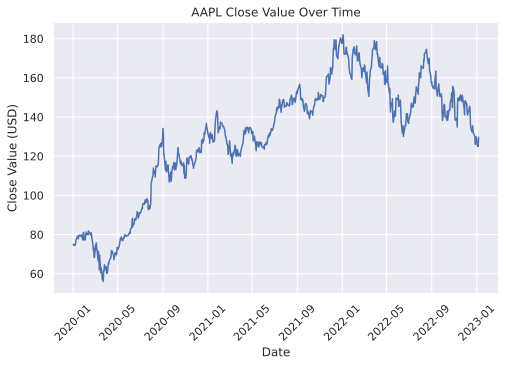

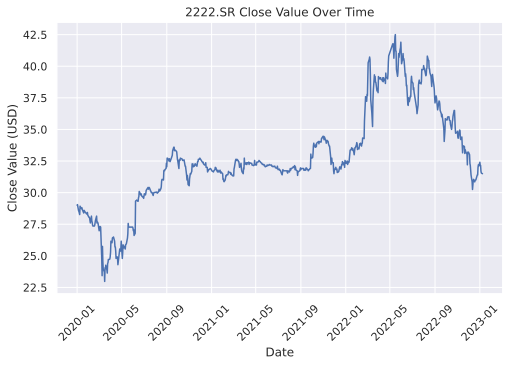

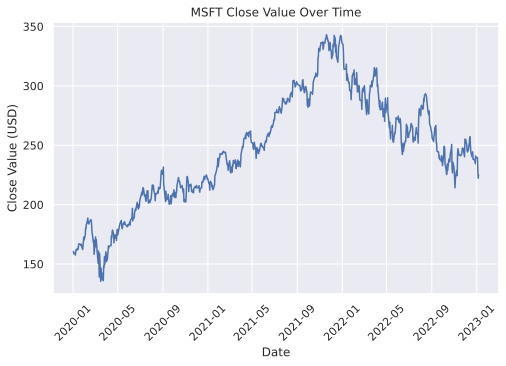

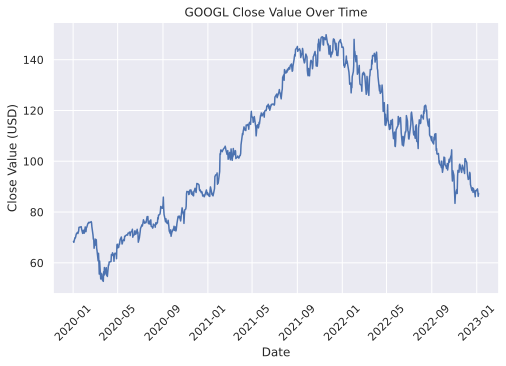

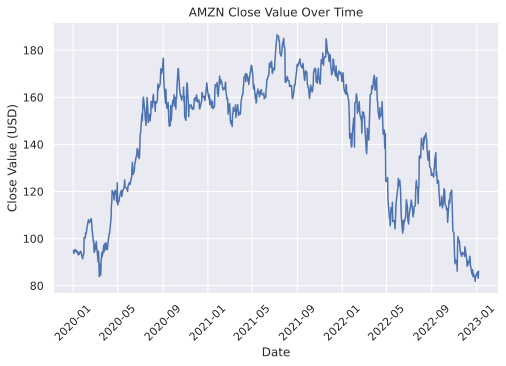

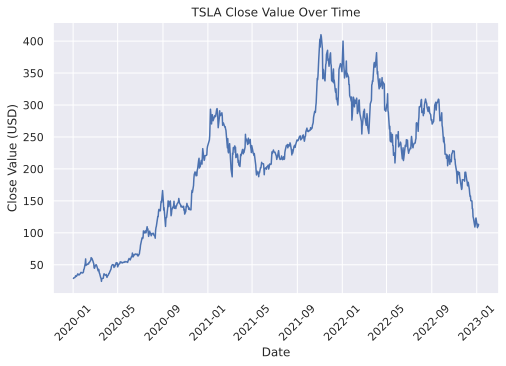

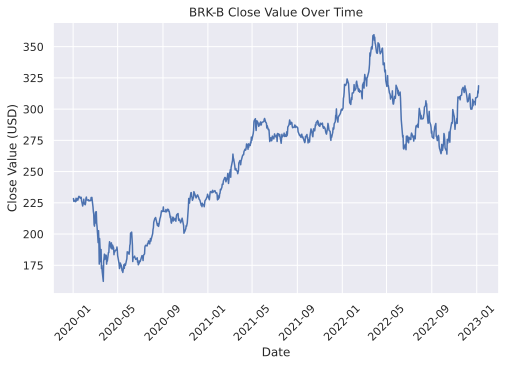

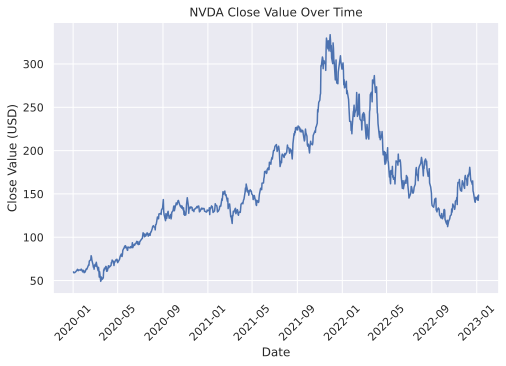

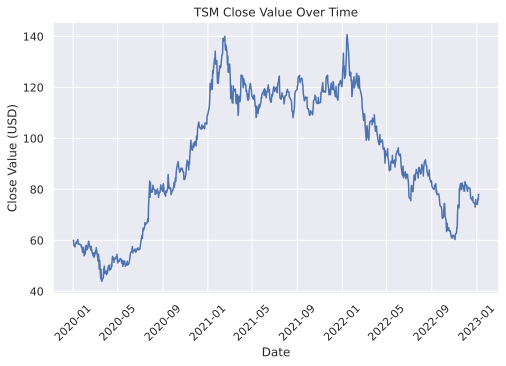

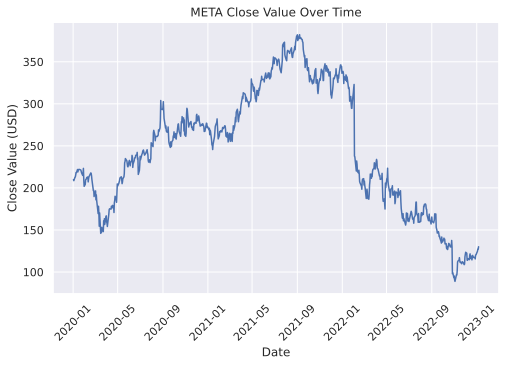

In [8]:
plot_stock_value(df, stocks)

The EDA suggests that **the market has been bearish since mids 2021**. At the end of 2022 and begining of 2023, all stocks but BRK-B have decreased their value to the 2020 levels.

Notwithstanding the above, the data collected from *Yahoo Finance* through **yfinance** seems to be complete and consistent.

___
## **4. Data Preparation**
___

Stock data value was cleaned and processed to calculate the **daily returns** which serves as a basis for the portfolio optimization.

#### **4.1 Data Cleaning**

The stock data from Saudi Aramco (2222.SR) is one day off from the rest of the stocks in the portfolio. For sake of consistency and simplicity, the close values of 2222.SR were aligned with the rest of stocks.

In [9]:
# Storing Saudi Aramco Close Values into a list
SA = list(df['2222.SR'])
print(SA[:5])
print(SA[-5:-1])

[29.008264541625977, 29.049585342407227, nan, 28.55371856689453, 28.51239585876465]
[32.150001525878906, 31.700000762939453, 31.549999237060547, nan]


In [10]:
# Adding a NaN value at the beginning of the list and removing list's last value
SA.insert(0, np.nan)
SA = SA[:-1]
print(SA[:5])
print(SA[-5:-1])

[nan, 29.008264541625977, 29.049585342407227, nan, 28.55371856689453]
[32.150001525878906, 32.150001525878906, 31.700000762939453, 31.549999237060547]


In [11]:
# Creating new 2222.SR_ colum with the adjusted Saudi Aramco values and drop of the original column
df['2222.SR_'] = SA
df = df.drop(columns = '2222.SR').rename(columns = {'2222.SR_': '2222.SR'})
df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684000,60.040001,29.008265
2020-01-03,74.357498,93.748497,226.179993,68.075996,208.669998,158.619995,59.017502,29.534000,58.060001,29.049585
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,74.949997,95.143997,226.990005,69.890503,212.600006,159.029999,59.264999,30.102667,57.389999,28.553719


In [12]:
# Removal of null values
df = df.dropna()
df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2020-01-02,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684000,60.040001,29.008265
2020-01-03,74.357498,93.748497,226.179993,68.075996,208.669998,158.619995,59.017502,29.534000,58.060001,29.049585
2020-01-06,74.949997,95.143997,226.990005,69.890503,212.600006,159.029999,59.264999,30.102667,57.389999,28.553719
2020-01-07,74.597504,95.343002,225.919998,69.755501,213.059998,157.580002,59.982498,31.270666,58.320000,28.512396
2020-01-08,75.797501,94.598503,225.990005,70.251999,215.220001,160.089996,60.095001,32.809334,58.750000,28.388430


#### **4.2 Calculation of the Daily Returns**

Based of the close value for each stock, the daily returns were calculated. To do so a function for getting the daily returns was defined.

In [13]:
# Function to get daily returns

def get_daily_returns(series):
    """
    Returns a list of daily returns of a pandas series of stock data values.
    
    Parameters

    series: A pandas series of daily stock close values.

    Returns 

    returns: A list of daily returns.


    """
    returns = []
    stock_values = list(series)

    for i in range(1, len(stock_values)):
        try:
            return_i = (stock_values[i + 1] - stock_values[i]) / stock_values[i]
            returns.append(return_i)
        except:
            pass

    return returns

In [14]:
# Getting daily returns for each stock and creating a new returns dataframe
AAPL_r = get_daily_returns(df['AAPL'])
AMZN_r = get_daily_returns(df['AMZN'])
BRKB_r = get_daily_returns(df['BRK-B'])
GOOGL_r = get_daily_returns(df['GOOGL'])
META_r = get_daily_returns(df['META'])
MSFT_r = get_daily_returns(df['MSFT'])
NVDA_r = get_daily_returns(df['NVDA'])
TSLA_r = get_daily_returns(df['TSLA'])
TSM_r = get_daily_returns(df['TSM'])
SR_r = get_daily_returns(df['2222.SR'])

returns_df = pd.DataFrame(
    {'AAPL': AAPL_r,
     'AMZN': AMZN_r,
     'BRK-B': BRKB_r,
     'GOOGL': GOOGL_r,
     'META': META_r,
     'MSFT': MSFT_r,
     'NVDA': NVDA_r,
     'TSLA': TSLA_r,
     'TSM': TSM_r,
     '2222.SR': SR_r
    })

returns_df.index = df.index[1:-1] # Dropping first and last date values
returns_df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2020-01-03,0.007968,0.014886,0.003581,0.026654,0.018834,0.002585,0.004194,0.019255,-0.011540,-0.017070
2020-01-06,-0.004703,0.002092,-0.004714,-0.001932,0.002164,-0.009118,0.012107,0.038801,0.016205,-0.001447
2020-01-07,0.016086,-0.007809,0.000310,0.007118,0.010138,0.015928,0.001876,0.049205,0.007373,-0.004348
2020-01-08,0.021241,0.004799,0.011770,0.010498,0.014311,0.012493,0.010983,-0.021945,0.008170,-0.004367
2020-01-09,0.002261,-0.009411,-0.008878,0.006459,-0.001099,-0.004627,0.005349,-0.006627,-0.006247,0.023392


In [15]:
returns_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 727 entries, 2020-01-03 to 2023-01-05
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     727 non-null    float64
 1   AMZN     727 non-null    float64
 2   BRK-B    727 non-null    float64
 3   GOOGL    727 non-null    float64
 4   META     727 non-null    float64
 5   MSFT     727 non-null    float64
 6   NVDA     727 non-null    float64
 7   TSLA     727 non-null    float64
 8   TSM      727 non-null    float64
 9   2222.SR  727 non-null    float64
dtypes: float64(10)
memory usage: 62.5 KB


In [16]:
returns_df.describe()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,0.001057,0.000202,0.000607,0.000586,-0.000143,0.000728,0.001907,0.002920,0.000731,0.000194
std,0.024311,0.025279,0.016443,0.022033,0.031346,0.022239,0.035705,0.046334,0.025512,0.012754
min,-0.128647,-0.140494,-0.095921,-0.116341,-0.263901,-0.147390,-0.184521,-0.210628,-0.140341,-0.090909
25%,-0.011410,-0.013169,-0.007101,-0.009822,-0.013412,-0.009711,-0.018861,-0.022199,-0.014852,-0.004307
50%,0.000246,0.000529,0.000621,0.001054,0.000648,0.000681,0.002897,0.001768,-0.000232,0.000000
75%,0.014410,0.012433,0.008086,0.012451,0.015185,0.012255,0.022738,0.024981,0.014375,0.004283
max,0.198469,0.135359,0.116099,0.092412,0.175936,0.142169,0.171564,0.198949,0.126522,0.098765


In [17]:
# Converting returns_df into a tidy format
returns_tidy_df = pd.melt(frame = returns_df, var_name = 'Stock', value_name = 'DailyReturn', ignore_index = False)
returns_tidy_df.head()

,Stock,DailyReturn
Date,,
2020-01-03,AAPL,0.007968
2020-01-06,AAPL,-0.004703
2020-01-07,AAPL,0.016086
2020-01-08,AAPL,0.021241
2020-01-09,AAPL,0.002261


In [18]:
returns_tidy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7270 entries, 2020-01-03 to 2023-01-05
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Stock        7270 non-null   object 
 1   DailyReturn  7270 non-null   float64
dtypes: float64(1), object(1)
memory usage: 170.4+ KB


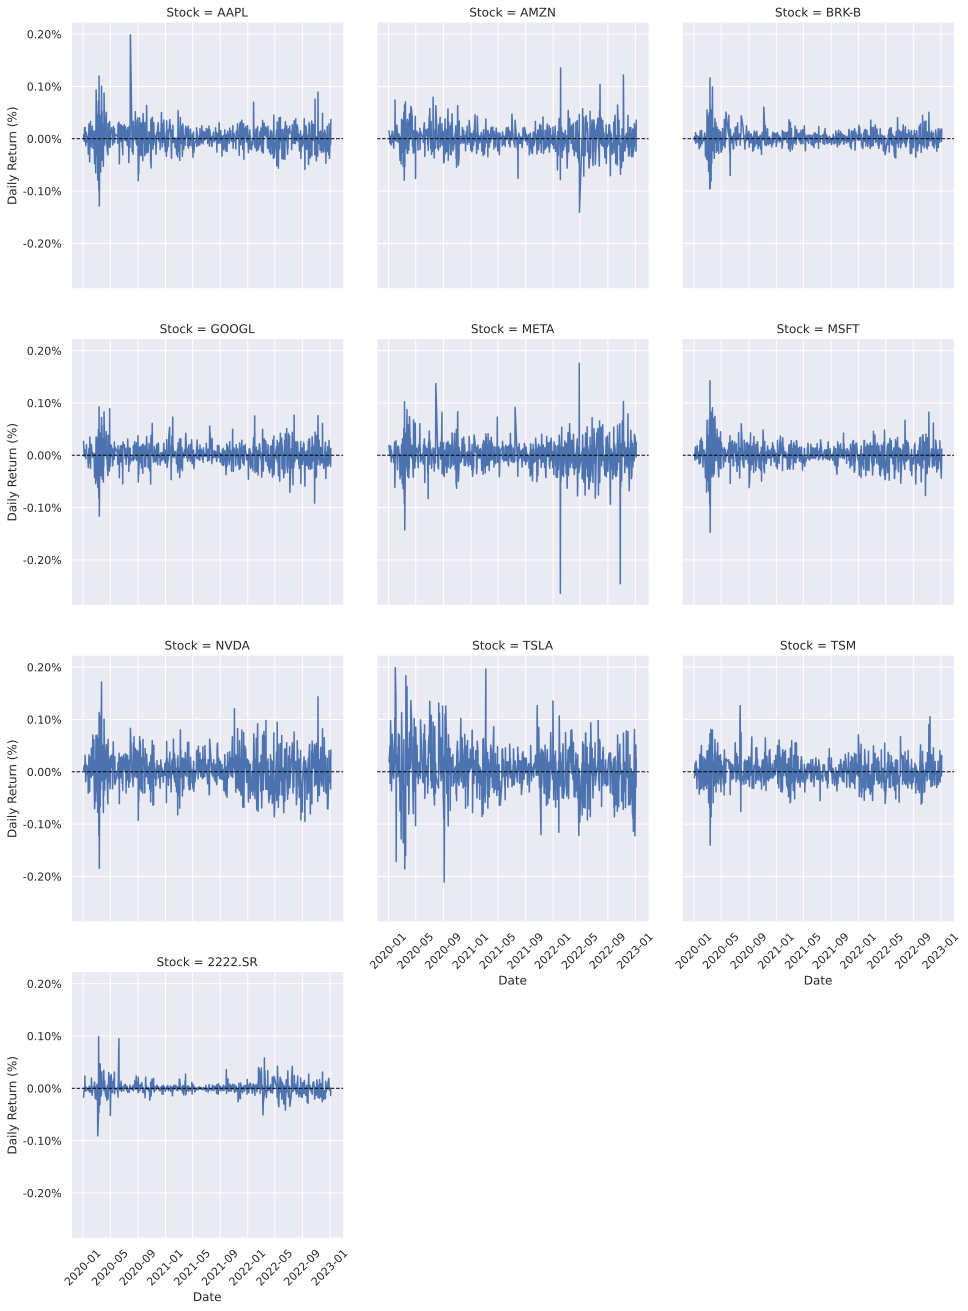

In [22]:
# Visualizing the daily returns for each stock
g = sns.relplot(data = returns_tidy_df, 
            x = returns_tidy_df.index, 
            y = 'DailyReturn', col = 'Stock',
            col_wrap = 3,  kind='line', palette = 'Blues_r',
            height = 4.5, aspect = 1,
            facet_kws={'sharey': True, 'sharex': True}
            )
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylabel('Daily Return (%)')
    ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '--')
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation = 45)
plt.show()

From the figures above, TSLA and NVDA daily returns are the most volatile; whereas the 2222.SR and BRK-B ones are the less.

#### **4.3 Optimization of the Stocks Portfolio**

Once the daily returns were calculated, the weight of each stock was optimized in the portfolio to maximize the return thereof using Convex optimization. This part of the analysis is based on XXX

In [23]:
# Turn off progress printing 
solvers.options['show_progress'] = False

In [193]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio.

    Parameters

    returns: Numpy array of the daily returns (rows) of a set of stocks (columns).    

    Returns

    mu: Scalar number with the expected return (mean) of the random portfolio.

    sigma: Scalar number with the volatility (standard deviation) of the random 
           portfolio.

    '''
    returns = returns.T
    
    # Number of assets/instruments
    n = returns.shape[0]
    
    # Produces n random weights that sum to 1 
    k = np.random.rand(n)
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(k / sum(k))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [194]:
def optimal_portfolio(returns, portfolios):
    """
    Optimization of a portfolio's expected return by minimizing overall instrument's risks.

    Parameters

    returns: Numpy array of the daily returns (rows) of a set of stocks (columns).

    portfolios: Number of portfolios to create to enable the optimization process.

    Returns

    weights: Numpy array with the optimized weights of the instruments of the 
             stocks porfolio.

    returns: List with the portfolios' expected returns.

    risks: List with the portfolios' estimated volatilities.

    """
    returns = returns.T
    n = returns.shape[0] # Number of assets/instruments
    
    N = portfolios
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    weights = np.asarray(wt)
    
    return weights, returns, risks

In [195]:
# Defining Returns Array
returns = returns_df.values
#returns = np.random.randn(10, 1000).T # Random returns

In [196]:
# Creation of 500 random portfolios
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(returns) 
    for _ in range(n_portfolios)
])

In [197]:
# Optimization of the stocks portfolio based on the historical daily returns
weights, returns, risks = optimal_portfolio(returns, 100)

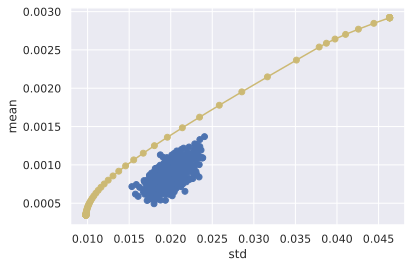

In [198]:
# Plot of the Efficient Frontier ("Markowitz bullet")
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [208]:
# Optimal Portfolio
weights_list = [i[0] for i in weights]
weights_list

[4.772169867853468e-07,
 3.953109141005689e-07,
 4.404893563345909e-07,
 4.3812299038402256e-07,
 3.59035771331658e-07,
 4.5302125547562114e-07,
 8.155423546668074e-08,
 0.9999965073034802,
 4.5333071378014306e-07,
 3.946142961996251e-07]

In [213]:
stocks_list = [i for i in returns_df.columns]
stocks_list

['AAPL',
 'AMZN',
 'BRK-B',
 'GOOGL',
 'META',
 'MSFT',
 'NVDA',
 'TSLA',
 'TSM',
 '2222.SR']

In [217]:
weights_df = pd.DataFrame(zip(*[returns_df.columns,weights_list])).rename(columns = {0: 'Stock', 1:'Weight'})
weights_df

,Stock,Weight
0,AAPL,4.772170e-07
1,AMZN,3.953109e-07
2,BRK-B,4.404894e-07
3,GOOGL,4.381230e-07
4,META,3.590358e-07
5,MSFT,4.530213e-07
6,NVDA,8.155424e-08
7,TSLA,9.999965e-01
8,TSM,4.533307e-07
9,2222.SR,3.946143e-07


Interestingly, the portfolio optimization yielded that most of the portfolio should be TSLA stocks (about 99%).

In [ ]:
# End